<a href="https://colab.research.google.com/github/MohammadSazid/My_Projects/blob/main/Dynamic%20Price%20Adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
data = pd.read_csv("dynamic_pricing.csv")

In [ ]:
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [ ]:
data.isna().sum()

,0
Number_of_Riders,0
Number_of_Drivers,0
Location_Category,0
Customer_Loyalty_Status,0
Number_of_Past_Rides,0
Average_Ratings,0
Time_of_Booking,0
Vehicle_Type,0
Expected_Ride_Duration,0
Historical_Cost_of_Ride,0


In [ ]:
data.duplicated().sum()

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB


In [ ]:
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [ ]:
fig = px.scatter(data, x='Expected_Ride_Duration',
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs. Historical Cost of Ride',
                 trendline='ols')
fig.show()

In [ ]:
fig = px.box(data, x='Vehicle_Type',
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution by Vehicle Type')
fig.show()

In [ ]:
categorical_features = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']
label_encoder = LabelEncoder()
for feature in categorical_features:
    data[feature] = label_encoder.fit_transform(data[feature])

In [ ]:
corr_matrix = data.corr()
fig = go.Figure(data=go.Heatmap(z=corr_matrix.values,
                                x=corr_matrix.columns,
                                y=corr_matrix.columns,
                                colorscale='Viridis'))
fig.update_layout(title='Correlation Matrix')
fig.show()

In [ ]:
# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

In [ ]:
# Calculate the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]


import plotly.graph_objects as go

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()

In [ ]:
fig = px.scatter(data,
                 x='Expected_Ride_Duration',
                 y='adjusted_ride_cost',
                 title='Expected Ride Duration vs. Cost of Ride',
                 trendline='ols')
fig.show()

<ipython-input-20-8f81d236eccd>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning

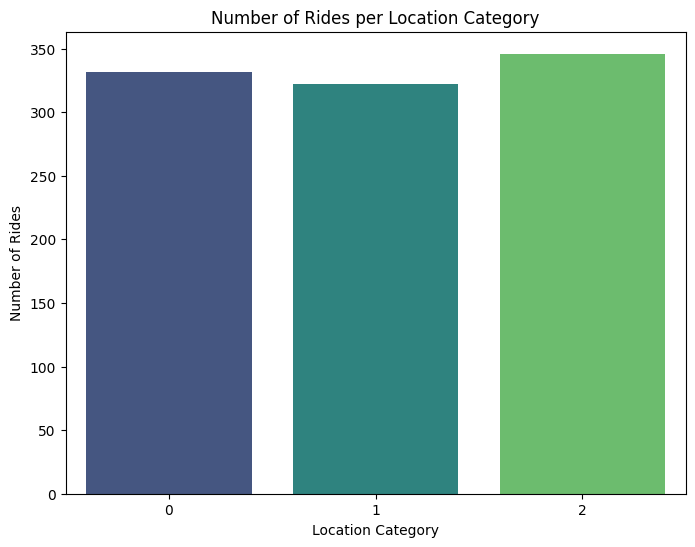

In [ ]:
# Bar plot of number of rides per location category
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Location_Category', palette='viridis')
plt.title('Number of Rides per Location Category')
plt.xlabel('Location Category')
plt.ylabel('Number of Rides')
plt.show()

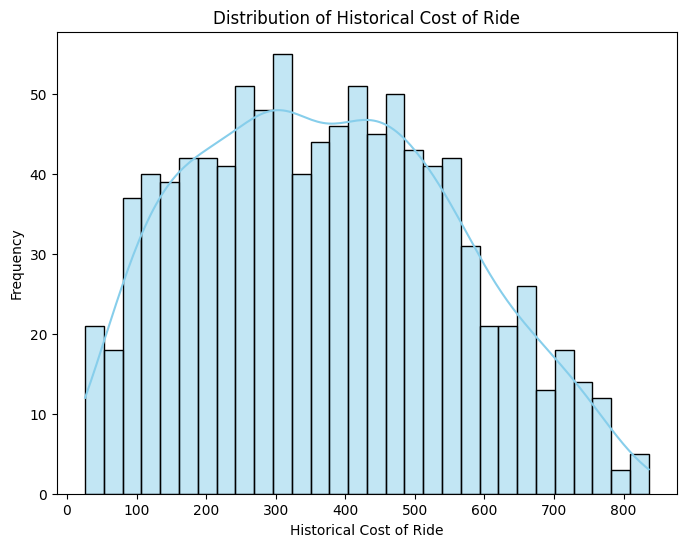

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Historical_Cost_of_Ride'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Historical Cost of Ride')
plt.xlabel('Historical Cost of Ride')
plt.ylabel('Frequency')
plt.show()

<ipython-input-22-db7ae29666b1>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

Se

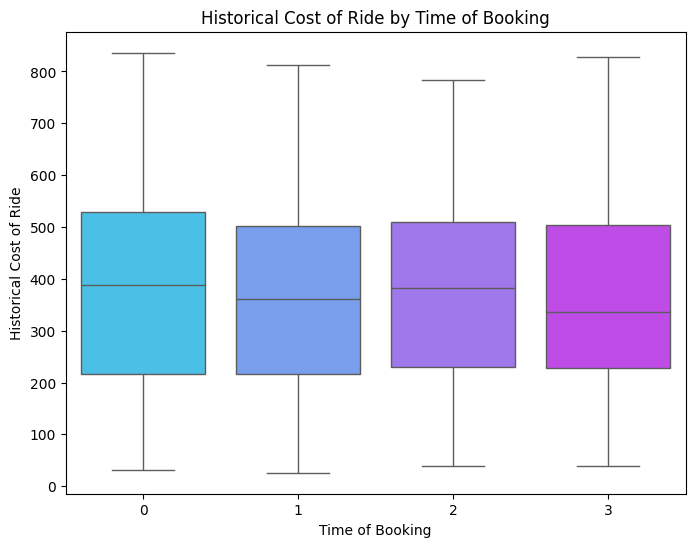

In [ ]:
# Boxplot of Historical Cost of Ride by Time of Booking
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Time_of_Booking', y='Historical_Cost_of_Ride', palette='cool')
plt.title('Historical Cost of Ride by Time of Booking')
plt.xlabel('Time of Booking')
plt.ylabel('Historical Cost of Ride')
plt.show()


<ipython-input-23-a159885b1fac>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning

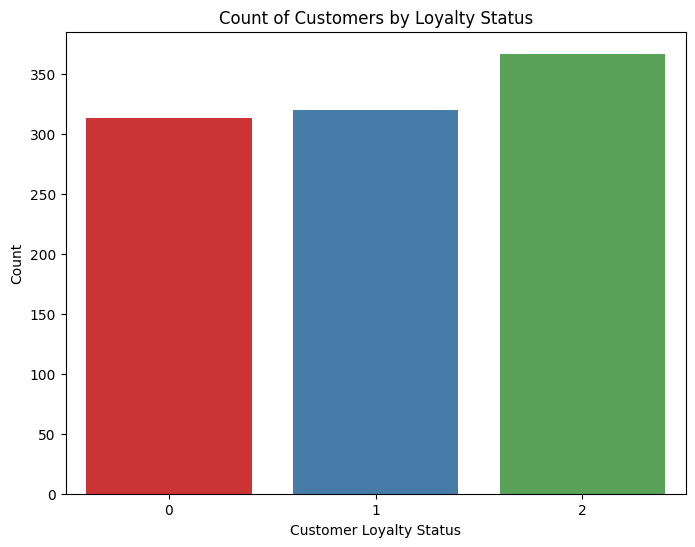

In [ ]:
# Countplot of Customer Loyalty Status
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Customer_Loyalty_Status', palette='Set1')
plt.title('Count of Customers by Loyalty Status')
plt.xlabel('Customer Loyalty Status')
plt.ylabel('Count')
plt.show()


In [ ]:
def data_preprocessing_pipeline(data):
    #Identify numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature])

    #Handle missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

In [ ]:
data["Vehicle_Type"] = data["Vehicle_Type"].map({"Premium": 1,
                                           "Economy": 0})

In [ ]:
#splitting data
from sklearn.model_selection import train_test_split
x = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(data[["adjusted_ride_cost"]])
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

In [ ]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
print(y_pred)

[ 489.29686151  799.11740992  899.81726794  735.04258978  172.2644728
 1122.87780129  312.14331317  202.84849709  497.17323506  229.36725036
  623.44201586  446.39299011  135.84932756 1485.3766861   374.20522655
  788.58898939 1163.66362703  408.28035463  510.97956424  707.83951952
  918.90426889  180.87244265  244.8261398   613.94975996  577.51229167
 1411.25714225  242.5113855   995.38443579  461.09266683 1264.46007903
  576.98076355  147.24150558  683.62996527  291.32910515 1110.44149322
  511.12409043  396.29703478  258.66284701  370.05916553  346.17285315
 1002.36896481 1355.98814304  965.68778827 1519.15912058 1382.83682051
  492.61215527  805.50092097 1608.4512006   472.49235324 1310.53499991
 1133.04648045  433.5944705   879.58074004  492.15060834  518.51727944
  390.5213657   325.94972452 1441.96735948 1393.05170678  557.20235316
 1117.5633935   842.97663674  863.20037391  958.94949281 1831.53942058
  582.55247616  399.95115824  326.15254629  768.2988298   229.53959561
  474.3

In [ ]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# R-squared (R2 Score)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f"Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

Model Performance Metrics:
Mean Squared Error (MSE): 31392.39
Root Mean Squared Error (RMSE): 177.18
Mean Absolute Error (MAE): 123.14
R-squared (R2 Score): 0.86


In [ ]:
mape = (abs(y_test - y_pred) / y_test).mean() * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 22.69%
